In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# import libs

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc

import lightgbm as lgb
from lightgbm import log_evaluation, record_evaluation
from lightgbm.basic import _log_info


# load data

In [70]:
data_path = '/content/drive/MyDrive/dataset/comp5310/Patient_Survival_Prediction_clean_version.csv'
df = pd.read_csv(data_path, index_col=0)
df.head()

,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_id,icu_stay_type,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
0,118,68.0,22.73,0,Caucasian,M,180.3,Floor,92,admit,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
1,81,77.0,27.42,0,Caucasian,F,160.0,Floor,90,admit,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
2,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,93,admit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
3,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,92,admit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
5,83,67.0,27.56,0,Caucasian,M,190.5,Accident & Emergency,95,admit,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic,0


In [71]:
(df.hospital_death == 0).sum() / (df.hospital_death == 1).sum()

11.154169079328314

# pre-processing

In [72]:
# Bool features
bool_col = ['elective_surgery', 'apache_post_operative', 'arf_apache', 'gcs_unable_apache', 'intubated_apache',
       'ventilated_apache', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
        'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']
df[bool_col] = df[bool_col].apply(lambda x: x.replace(0, False).replace(1, True))
df['gender'] = df['gender'].replace('M', False).replace('F', True)  # False: M,  True: F


In [73]:
# Object features
object_col = ['ethnicity', 'icu_admit_source', 'icu_stay_type', 
        'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']

df_dummies = pd.get_dummies(df[object_col])
df_dummies = df_dummies.apply(lambda x: x.replace(0, False).replace(1, True))
df = df.drop(object_col, axis=1)

df = pd.concat([df, df_dummies], axis=1)

In [74]:
df.head()

,hospital_id,age,bmi,elective_surgery,gender,height,icu_id,pre_icu_los_days,weight,apache_2_diagnosis,...,apache_2_bodysystem_Cardiovascular,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Other,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses
0,118,68.0,22.73,False,False,180.3,92,0.541667,73.9,113.0,...,True,False,False,False,False,False,False,False,False,False
1,81,77.0,27.42,False,True,160.0,90,0.927778,70.2,108.0,...,False,False,False,False,False,False,False,True,False,False
2,118,25.0,31.95,False,True,172.7,93,0.000694,95.3,122.0,...,False,False,False,True,False,False,False,False,False,False
3,118,81.0,22.64,True,True,165.1,92,0.000694,61.7,203.0,...,True,False,False,False,False,False,False,False,False,False
5,83,67.0,27.56,False,False,190.5,95,0.000694,100.0,301.0,...,False,False,False,False,True,False,False,False,False,False


# split dataset

In [75]:
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(df.drop('hospital_death', axis=1), df.hospital_death, stratify=df.hospital_death, random_state=0)

# model

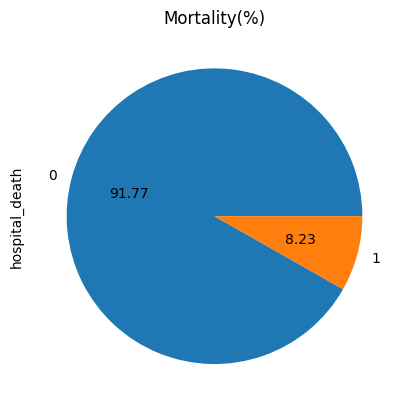

In [76]:
_ = y_train_data.value_counts().plot(kind='pie',autopct="%.2f",title ='Mortality(%)')

In [77]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_data), y=y_train_data)
sample_weights = np.array([class_weights[i] for i in y_train_data])
ds = lgb.Dataset(X_train_data, y_train_data, weight=sample_weights)

In [78]:
def lgb_recall_of_dead(y_pred, train_data):
    y_true = train_data.get_label()
    y_pred = [1 if i > 0.5 else 0 for i in y_pred]
    return 'recall_of_dead', recall_score(y_true, y_pred), True

def lgb_f1_score(y_pred, train_data):
    y_true = train_data.get_label()
    y_pred = [1 if i > 0.5 else 0 for i in y_pred]
    return 'f1_score', f1_score(y_true, y_pred, average='macro'), True

In [79]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=5310)

lr = 0.02

params = {
    'objective': 'binary',
    'verbose': 0,
    'metric': ['auc', 'binary_logloss'],
    'reg_alpha': 1,
    'reg_lambda': 1,
    'min_data_in_leaf': 20, 
    'max_depth': -1,
    'num_leaves': 32,
    'colsample_bytree': 0.7,
    'bagging_fraction': 0.7, 
    'learning_rate': lr,
}


In [80]:
ret = lgb.cv(params, 
        ds, 
        num_boost_round=4000, 
        folds=folds,
        feval=[lgb_recall_of_dead, lgb_f1_score], 
        stratified=True, 
        return_cvbooster=True, 
        callbacks=[log_evaluation(period=20)], 
        seed=5310)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[20]	cv_agg's auc: 0.873683 + 0

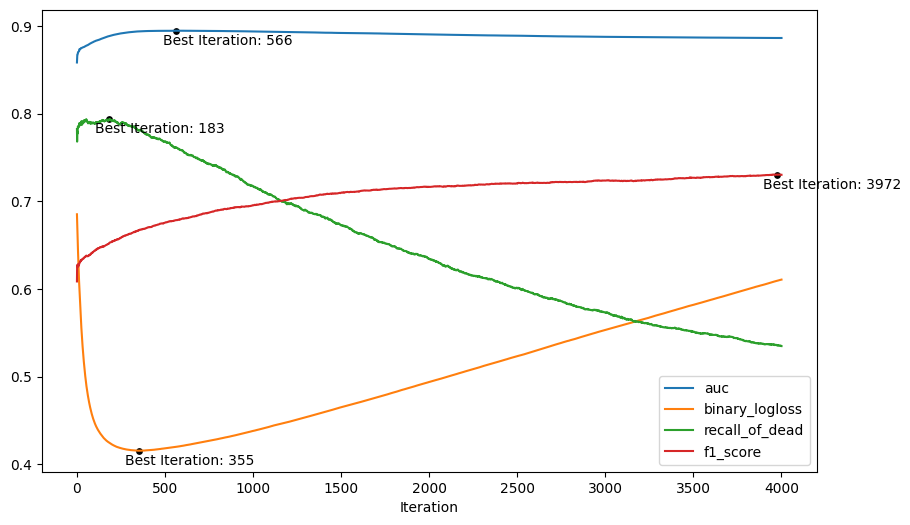

In [81]:
df_iteration = pd.DataFrame({'iteration': [i for i in range(1, 4001)], 'auc': ret['auc-mean'], 
                'binary_logloss': ret['binary_logloss-mean'], 'recall_of_dead': ret['recall_of_dead-mean'], 'f1_score': ret['f1_score-mean']})

plt.figure(figsize=(10, 6))

stop_points = [[df_iteration.loc[df_iteration['auc'].idxmax(), 'iteration'], df_iteration.loc[df_iteration['auc'].idxmax(), 'auc']], 
         [df_iteration.loc[df_iteration['binary_logloss'].idxmin(), 'iteration'], df_iteration.loc[df_iteration['binary_logloss'].idxmin(), 'binary_logloss']], 
         [df_iteration.loc[df_iteration['recall_of_dead'].idxmax(), 'iteration'], df_iteration.loc[df_iteration['recall_of_dead'].idxmax(), 'recall_of_dead']], 
         [df_iteration.loc[df_iteration['f1_score'].idxmax(), 'iteration'], df_iteration.loc[df_iteration['f1_score'].idxmax(), 'f1_score']]
        ]

for index, column in enumerate(['auc', 'binary_logloss', 'recall_of_dead', 'f1_score']):
    plt.plot(df_iteration['iteration'], df_iteration[column], label=column)
    plt.scatter(stop_points[index][0], stop_points[index][1], color='black', s=15)
    plt.annotate(f'Best Iteration: {stop_points[index][0]}', (stop_points[index][0], stop_points[index][1]), textcoords="offset points", xytext=(-10,-10))

plt.legend()

plt.xlabel('Iteration')

plt.show()

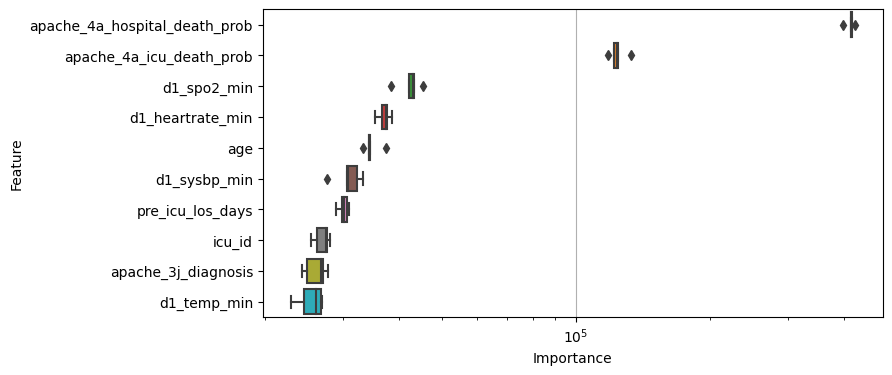

In [82]:
raw_importances = ret['cvbooster'].feature_importance(importance_type='gain')
feature_name = ret['cvbooster'].boosters[0].feature_name()
importance_df = pd.DataFrame(data=raw_importances, columns=feature_name)

sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

PLOT_TOP_N = 10
plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
_, ax = plt.subplots(figsize=(8, 4))
ax.grid()
ax.set_xscale('log')
ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
sns.boxplot(data=sorted_importance_df[plot_cols], orient='h', ax=ax)
plt.show()

In [83]:
boosters = []
for i in range(len(stop_points)):
    params['seed'] = i
    boosters.append(lgb.train(params, ds, num_boost_round=stop_points[i][0]))

class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict(self, x):
        predicted = np.zeros((len(x), len(self.models)))

        for i, m in enumerate(self.models):
            predicted[:, i] = m.predict(x)

        ttl = len(self.models)
        return np.sum(predicted, axis=1) / ttl

booster = EnsembleModel(boosters)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079821 seconds.
You can set `force_col_wise=true` to remove the overhead.


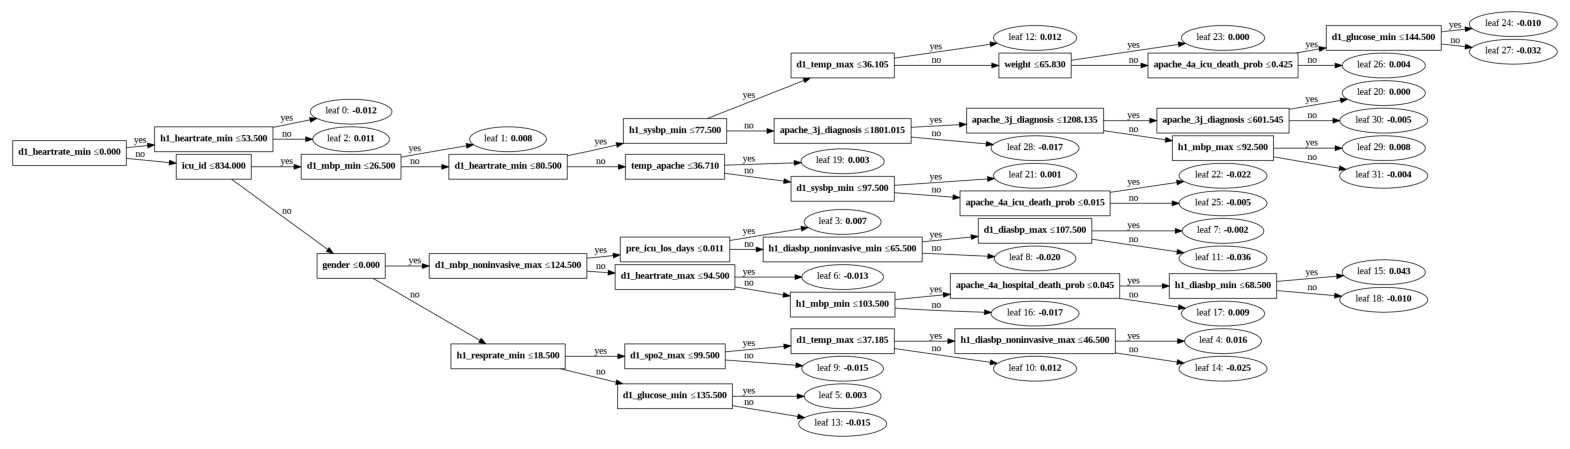

In [84]:
_, ax = plt.subplots(figsize=(20, 20))
lgb.plot_tree(boosters[1], tree_index=stop_points[1][0]-1, ax=ax) # binary_logloss
plt.show()

# evaluate

In [85]:
def plt_roc(y_train_data, pred_logits_train, y_test_data, pred_logits, name):
    fpr_test, tpr_test, _ = roc_curve(y_test_data, pred_logits)
    fpr_train, tpr_train, _ = roc_curve(y_train_data, pred_logits_train)

    roc_auc_test = auc(fpr_test, tpr_test)
    roc_auc_train = auc(fpr_train, tpr_train)

    plt.figure()
    plt.plot(fpr_test, tpr_test, color='red', label='Test ROC curve (area = %0.2f)' % roc_auc_test)
    plt.plot(fpr_train, tpr_train, color='black', label='Train ROC curve (area = %0.2f)' % roc_auc_train)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('Recall')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.show()

              precision    recall  f1-score   support

           0       0.99      0.89      0.94     57789
           1       0.43      0.94      0.59      5181

    accuracy                           0.89     62970
   macro avg       0.71      0.91      0.76     62970
weighted avg       0.95      0.89      0.91     62970

[[51230  6559]
 [  323  4858]]
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     19264
           1       0.32      0.72      0.45      1727

    accuracy                           0.85     20991
   macro avg       0.65      0.79      0.68     20991
weighted avg       0.92      0.85      0.88     20991

[[16673  2591]
 [  480  1247]]


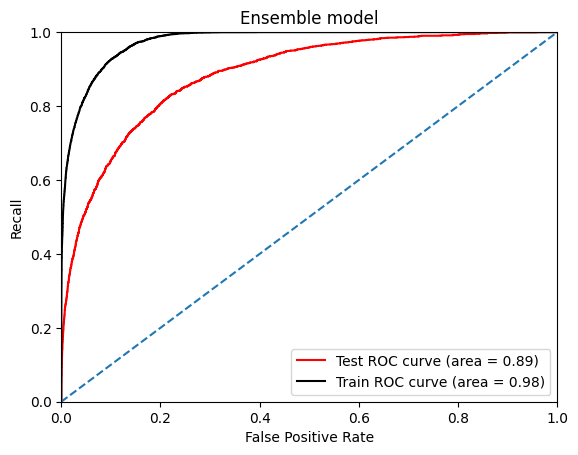

In [86]:
# train
pred_logits_train = booster.predict(X_train_data)
pred_train = [1 if i > 0.5 else 0 for i in pred_logits_train]
print(metrics.classification_report(y_train_data, pred_train))
print(metrics.confusion_matrix(y_train_data, pred_train))

# test
pred_logits = booster.predict(X_test_data)
pred = [1 if i > 0.5 else 0 for i in pred_logits]
print(metrics.classification_report(y_test_data, pred))
print(metrics.confusion_matrix(y_test_data, pred))

plt_roc(y_train_data, pred_logits_train, y_test_data, pred_logits, 'Ensemble model')

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     57789
           1       0.36      0.91      0.52      5181

    accuracy                           0.86     62970
   macro avg       0.68      0.89      0.72     62970
weighted avg       0.94      0.86      0.89     62970

[[49506  8283]
 [  447  4734]]
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     19264
           1       0.30      0.76      0.43      1727

    accuracy                           0.83     20991
   macro avg       0.64      0.80      0.67     20991
weighted avg       0.92      0.83      0.86     20991

[[16206  3058]
 [  419  1308]]


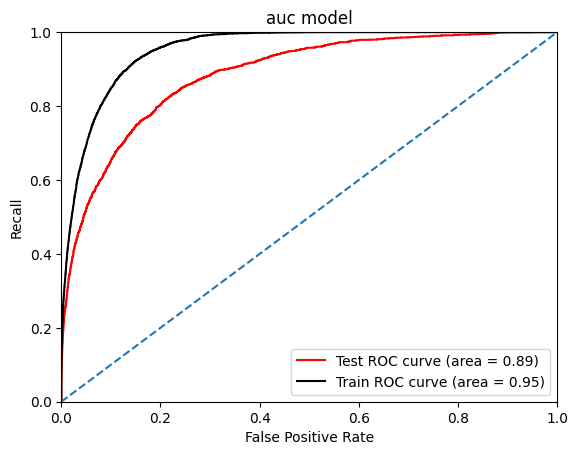

In [87]:
# train
pred_logits_train_0 = boosters[0].predict(X_train_data)
pred_train_0 = [1 if i > 0.5 else 0 for i in pred_logits_train_0]
print(metrics.classification_report(y_train_data, pred_train_0))
print(metrics.confusion_matrix(y_train_data, pred_train_0))

# test
pred_logits_0 = boosters[0].predict(X_test_data)
pred_0 = [1 if i > 0.5 else 0 for i in pred_logits_0]
print(metrics.classification_report(y_test_data, pred_0))
print(metrics.confusion_matrix(y_test_data, pred_0))

plt_roc(y_train_data, pred_logits_train_0, y_test_data, pred_logits_0, 'auc model')

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     57789
           1       0.33      0.88      0.48      5181

    accuracy                           0.84     62970
   macro avg       0.66      0.86      0.69     62970
weighted avg       0.93      0.84      0.87     62970

[[48422  9367]
 [  612  4569]]
              precision    recall  f1-score   support

           0       0.98      0.82      0.89     19264
           1       0.28      0.78      0.42      1727

    accuracy                           0.82     20991
   macro avg       0.63      0.80      0.65     20991
weighted avg       0.92      0.82      0.85     20991

[[15881  3383]
 [  388  1339]]


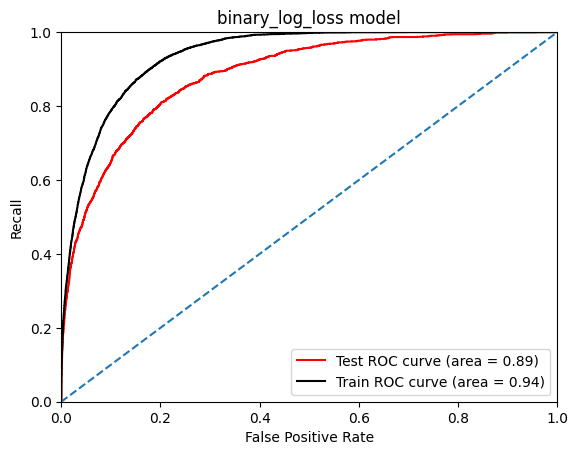

In [88]:
# train
pred_logits_train_1 = boosters[1].predict(X_train_data)
pred_train_1 = [1 if i > 0.5 else 0 for i in pred_logits_train_1]
print(metrics.classification_report(y_train_data, pred_train_1))
print(metrics.confusion_matrix(y_train_data, pred_train_1))

# test
pred_logits_1 = boosters[1].predict(X_test_data)
pred_1 = [1 if i > 0.5 else 0 for i in pred_logits_1]
print(metrics.classification_report(y_test_data, pred_1))
print(metrics.confusion_matrix(y_test_data, pred_1))

plt_roc(y_train_data, pred_logits_train_1, y_test_data, pred_logits_1, 'binary_log_loss model')

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     57789
           1       0.30      0.85      0.44      5181

    accuracy                           0.82     62970
   macro avg       0.64      0.84      0.67     62970
weighted avg       0.93      0.82      0.86     62970

[[47342 10447]
 [  758  4423]]
              precision    recall  f1-score   support

           0       0.98      0.81      0.88     19264
           1       0.27      0.78      0.40      1727

    accuracy                           0.81     20991
   macro avg       0.62      0.80      0.64     20991
weighted avg       0.92      0.81      0.85     20991

[[15583  3681]
 [  373  1354]]


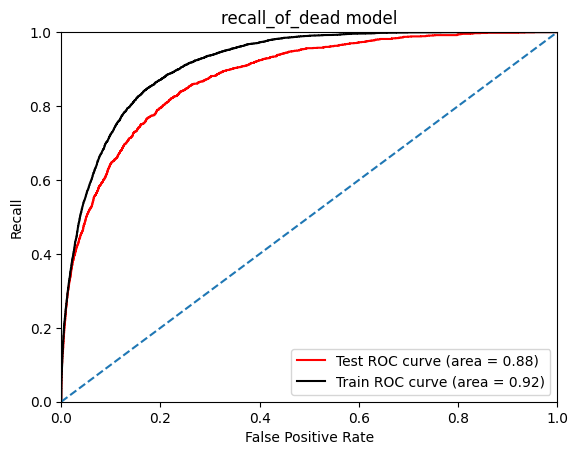

In [89]:
# train
pred_logits_train_2 = boosters[2].predict(X_train_data)
pred_train_2 = [1 if i > 0.5 else 0 for i in pred_logits_train_2]
print(metrics.classification_report(y_train_data, pred_train_2))
print(metrics.confusion_matrix(y_train_data, pred_train_2))

# test
pred_logits_2 = boosters[2].predict(X_test_data)
pred_2 = [1 if i > 0.5 else 0 for i in pred_logits_2]
print(metrics.classification_report(y_test_data, pred_2))
print(metrics.confusion_matrix(y_test_data, pred_2))

plt_roc(y_train_data, pred_logits_train_2, y_test_data, pred_logits_2, 'recall_of_dead model')

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     57789
           1       0.82      1.00      0.90      5181

    accuracy                           0.98     62970
   macro avg       0.91      0.99      0.94     62970
weighted avg       0.98      0.98      0.98     62970

[[56631  1158]
 [    3  5178]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     19264
           1       0.43      0.56      0.49      1727

    accuracy                           0.90     20991
   macro avg       0.70      0.74      0.72     20991
weighted avg       0.92      0.90      0.91     20991

[[18001  1263]
 [  768   959]]


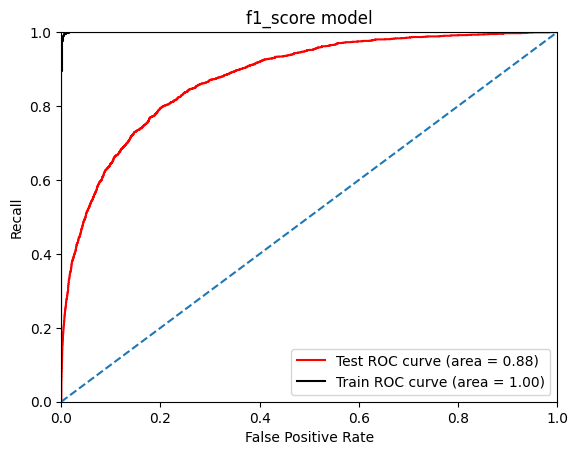

In [90]:
# train
pred_logits_train_3 = boosters[3].predict(X_train_data)
pred_train_3 = [1 if i > 0.5 else 0 for i in pred_logits_train_3]
print(metrics.classification_report(y_train_data, pred_train_3))
print(metrics.confusion_matrix(y_train_data, pred_train_3))

# test
pred_logits_3 = boosters[3].predict(X_test_data)
pred_3 = [1 if i > 0.5 else 0 for i in pred_logits_3]
print(metrics.classification_report(y_test_data, pred_3))
print(metrics.confusion_matrix(y_test_data, pred_3))

plt_roc(y_train_data, pred_logits_train_3, y_test_data, pred_logits_3, 'f1_score model')